# Transfer Learning (RoBERTa)

Previously, we [successfully built an LSTM model](./04-lstm.ipynb) that used sequential information to improve the final result. Now, we take the final step in our journey by using a transformer model, the current **state-of-the-art** architecture for most natural language processing tasks.

## Data Preparation

In [1]:
from datasets import load_dataset
import numpy as np

train, test = load_dataset('stanfordnlp/imdb', split=['train', 'test'])
class_names = train.features['label'].names

x_train = np.array(train['text'])
y_train = np.array(train['label'])
x_test = np.array(test['text'])
y_test = np.array(test['label'])

## Data Encoding

This is where things drastically change. Unlike our previous attempt, where we managed our own vocabulary and embedding matrix, transformer models come with their own dedicated tokenizers.

The tokenizer and the pre-trained model are a matched pair - the tokenizer knows the exact vocabulary and the specific rules the model was trained with. It handles tokenization automatically.

In [2]:
from transformers import RobertaTokenizerFast
tokenizer = RobertaTokenizerFast.from_pretrained('distilbert/distilroberta-base')
tokenizer_params = {
    'return_tensors': 'np',
    'max_length': 284,
    'truncation': True,
    'padding': True,
}

We are going to pad and truncate the sequences to the same length as our previous model for the sake of consistency - though, those values could be considered hyperparameters too.

In [3]:
x_train = dict(tokenizer(x_train.tolist(), **tokenizer_params))
x_test = dict(tokenizer(x_test.tolist(), **tokenizer_params))

## Building and Training the Model

Unlike LSTMs which process text sequentially one word at a time, **transformers process the entire sequence at once**. The magic ingredient is the **self-attention mechanism**. For every word in the sentence, it weighs the influence of all other words and identifies which ones are most relevant to its meaning in that specific context.

Is a "bank" a financial institution or the side of a river? Attention helps figure this out by looking at the surrounding words. By stacking these attention layers, the model builds a rich, context-aware representation of the entire text, making it incredibly accurate.

For our experiment, we are going to use the pre-trained **DistilRoBERTa** model. Don't be scared by its name - it's a **R**obustly **O**ptimized version of the original **BERT** architecture. We are going to use a **distilled** version of it - it's a bit simpler, but much faster and easier to train.

In [4]:
%env TF_USE_LEGACY_KERAS=1
from transformers import TFRobertaForSequenceClassification as RobertaForSequenceClassification
from transformers import logging, set_seed

logging.set_verbosity_error()
set_seed(0)

model = RobertaForSequenceClassification.from_pretrained(
    'distilbert/distilroberta-base', 
    num_labels=len(class_names),
)

env: TF_USE_LEGACY_KERAS=1


You might notice the environment variable flag being set - unfortunately, the `transformers` library still uses the old [Keras version](https://github.com/huggingface/transformers/issues/34761) for its core functionality, and we need to take that into account.

Next, we need to prepare an optimization routine. We might use the transformers pipeline instead of a built-in TensorFlow toolset - mostly because they were created with fine-tuning of those models in mind.

In [5]:
from transformers import create_optimizer

epochs = 3
validation_split = 0.2
batch_size = 32

num_train_steps = epochs * (len(x_train['input_ids']) * (1 - validation_split) // batch_size)
optimizer, _ = create_optimizer(
    init_lr=0.00002,
    weight_decay_rate=0.01,
    num_warmup_steps=int(num_train_steps * 0.1),
    num_train_steps=num_train_steps
)

Finally, we may raise the dropout rates of our model a bit - it would potentially make it more robust and less prone to overfitting due to the small dataset size.

In [6]:
model.config.attention_probs_dropout_prob = 0.2
model.config.hidden_dropout_prob = 0.2

We may start training our model now.

In [7]:
from tensorflow import device
with device('/GPU'):
    model.compile(optimizer=optimizer, metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)

Epoch 1/3
625/625 [==============================] - 1485s 2s/step - loss: 0.3190 - accuracy: 0.8575 - val_loss: 0.3633 - val_accuracy: 0.8434
Epoch 2/3
625/625 [==============================] - 1482s 2s/step - loss: 0.1819 - accuracy: 0.9291 - val_loss: 0.2942 - val_accuracy: 0.8962
Epoch 3/3
625/625 [==============================] - 1447s 2s/step - loss: 0.1365 - accuracy: 0.9498 - val_loss: 0.2923 - val_accuracy: 0.9022


## Result

In [8]:
from sklearn.metrics import classification_report
with device('/GPU'):
    y_pred_values = model.predict(x_test, verbose=True).logits
    y_pred_labels = np.argmax(y_pred_values, axis=1)
    print(classification_report(y_test, y_pred_labels, target_names=class_names))

782/782 [==============================] - 479s 612ms/step
              precision    recall  f1-score   support

         neg       0.92      0.94      0.93     12500
         pos       0.94      0.91      0.93     12500

    accuracy                           0.93     25000
   macro avg       0.93      0.93      0.93     25000
weighted avg       0.93      0.93      0.93     25000



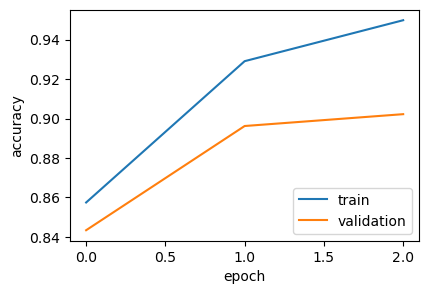

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4.5, 3))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()

## Conclusion

With a final accuracy of **93%**, this transformer-based approach has decisively outperformed all of our previous models. What's more, the validation accuracy curve tracks the training accuracy almost perfectly, indicating that our regularization strategies were effective in preventing overfitting.

This leap in performance underscores the power of the self-attention mechanism in capturing complex language patterns and contextual nuances, something simpler models usually struggle with. It marks a significant milestone in our exploration, demonstrating how moving towards more sophisticated architectures can unlock a superior understanding of text.